In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time
import warnings
warnings.filterwarnings("ignore")

import string
import random
import unicodedata

import codecs
import re
import os.path

from sklearn import *
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD # to reduce dimension in order to prevent from overfitting

from collections import defaultdict, OrderedDict

import nltk
from nltk.corpus import *
from nltk.stem import *
# nltk.download('stopwords')
# nltk.download('punkt')

# Données reconnaissance du locuteur (Chirac/Mitterrand)

# A) Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

# Données classification de sentiments (films)

In [2]:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs  

In [3]:
path = "./movies1000/"

alltxts,alllabs = load_movies(path)

WE DEFINE OUR GENERALIZED PREPROCESSING FUNCTION BELOW : 

In [4]:
def preproc(alltxts,
            sep_titre_resume=False, # more normal way to treat data if we dont separate, and a normal speech or dialog doesn't have any intro or conclusion
            normalization=True, # we strongly recommend to let it true
            lowercase=True,
            remove_punc=True, # punctuation
            remove_numbers=True,
            remove_sw=True, # sw stands for stopwords
            language="english", # most common language
            lemmatization=True, # we didn't integrate stemming in our preprocessing, we think that lemmatization only is more accurate (even though it needs more resources)
            bytepair_enc=True, # finding most common pairs of words is really informative (if we remove stop words)
            bytepairs_size=0, # max_value = 21, min_value = 1
            ngram=(2,3), # most common ngram range
            maxdf=0.95, # found this value in TMEs
            mindf=2, # same
            maxfeatures=1000, # same
            bin_enc=False): # binary BoW works well on feelings classification (as RITAL course said)
    '''
    Returns the train dataset or the test dataset we will use for our learning process
    @param alltxts : raw texts
    other params are to toggle whether we use associated preproc
    '''
    
    if sep_titre_resume:
        # Séparation en titre/résumé
        debut = time.time()
        for i in range(len(alltxts)):
            sp = alltxts[i].split('.')
            if len(sp)>1:
                alltxts[i] = sp[0] + " " + sp[-2]
            else:
                alltxts[i] = sp[0]
        fin = time.time()
        
        print("Temps de séparation sous la forme titre/résumé :", fin - debut)
        
    if normalization:
        # Suppr accents et encodage en ascii
        debut = time.time()
        for i in range(len(alltxts)):
            alltxts[i] = unicodedata.normalize('NFD', alltxts[i]).encode('ascii', 'ignore').decode("utf-8")
        fin = time.time()
        
        print("Temps de normalisation :", fin - debut)
        
    
    if lowercase:
        # Suppr minuscules :
        debut = time.time()
        for i in range(len(alltxts)):
            alltxts[i] = alltxts[i].lower()
        fin = time.time()
        
        print("Temps de mise en minuscule :", fin - debut)
        
    
    if remove_punc:
        # Suppr ponctuation :
        debut = time.time()
        punc = string.punctuation
        punc += '\n\r\t'
        for i in range(len(alltxts)):
            alltxts[i] = alltxts[i].translate(str.maketrans(punc, ' ' * len(punc)))
        fin = time.time()
        
        print("Temps de suppression de la ponctuation :", fin - debut)
        
    
    if remove_numbers:
        # Suppr nombres
        debut = time.time()
        for i in range(len(alltxts)):
            alltxts[i] = re.sub('[0-9]+', '', alltxts[i]) # remplacer une séquence de chiffres par rien
            alltxts[i] = re.sub('[ ]+', ' ', alltxts[i])
        fin = time.time()
        
        print("Temps de suppression des nombres :", fin - debut)
    
    
    if remove_sw:
        # Suppr stopwords
        debut = time.time()
        if language=="english":
            stopwords_list = stopwords.words('english')
        else:
            stopwords_list = stopwords.words('french')
        mots = []
        for i in range(len(alltxts)):
            token_textes = nltk.word_tokenize(alltxts[i])
            mots.append([])
            for t in token_textes:
                if t not in stopwords_list:
                    mots[i].append(t)

        for i in range(len(mots)):
            alltxts[i] = " ".join(mots[i])
        fin = time.time()
        
        print("Temps de suppression des stop words :", fin - debut)
        
    
    if lemmatization:
        # Lemmatization (we don't do stemming because we think it is less accurate than lemma)
        debut = time.time()
        lemmatizer = WordNetLemmatizer()
        lem_texte = []
        for i in range(len(alltxts)):
            token_textes = nltk.word_tokenize(alltxts[i])
            lem_texte.append([])
            for t in token_textes:
                lem_texte[i].append(lemmatizer.lemmatize(t))

        mots = []
        i = 0
        for t in lem_texte:
            mots.append([])
            for m in t:
                if len(m)>1:
                    mots[i].append(m)
            i += 1

        for i in range(len(mots)):
            alltxts[i] = " ".join(mots[i])
        fin = time.time()
            
        print("Temps de lemmatization :", fin - debut)
    
    
    if bytepair_enc:
        # Replace most frequent word pair (Byte-Pair encoding)
        debut = time.time()
        pair_freqs = defaultdict(int)

        # we compute the frequency of each pair in the corpus
        for text in alltxts:
            words = text.strip().split(" ")
            for i in range(len(words)-1):
                pair_freqs[words[i] + "_" + words[i+1]] += 1

        sorted_pairfreqs = dict(sorted(pair_freqs.items(),key= lambda x:x[1]))

        most_freq_pairs = list(sorted_pairfreqs.keys())

        bytepairs_size = bytepairs_size # hyper-parameter to toggle
        

        alphabet = ['B', 'C', 'D', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y', 'Z'] # tokens to replace most freq pairs
        
        if bytepairs_size > len(alphabet) or bytepairs_size<1:
            bytepairs_size = len(alphabet)
            
        if bytepairs_size > len(most_freq_pairs):
            bytepairs_size = len(most_freq_pairs)
        
        i_alph = 0
        for i in range(len(most_freq_pairs)-1, len(most_freq_pairs)-bytepairs_size-1, -1):
            to_change = most_freq_pairs[i].split("_")
            for j in range(len(alltxts)):
                words = alltxts[j].strip().split(" ")
                k = 0
                while k < len(words)-1 and len(words)>1:
                    if words[k] == to_change[0] and words[k+1] == to_change[1]:
                        words[k] = alphabet[i_alph]
                        words.pop(k+1)
                        k = 0
                    else:
                        k += 1
                
                alltxts[j] = " ".join(words)

            i_alph += 1
            
        fin = time.time()
            
        print("Temps de Byte-pair Encoding sur les paires de mots :", fin - debut)
    
    
    ngram_range = ngram
    
    # Tfidf is more accurate than Count
    if bin_enc:
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, analyzer='word', max_df=maxdf, min_df=mindf, max_features=maxfeatures, binary=True)
    else:
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, analyzer='word', max_df=maxdf, min_df=mindf, max_features=maxfeatures)
    
    
    
    debut = time.time()
    X = vectorizer.fit_transform(alltxts)
    fin = time.time()
    print("Temps de vectorisation :", fin - debut)
    
    '''
    if tsvd:
        # Réduction dimensionnelle, pas mal pour la gestion de l'overfitting
        if tsvd_size == None:
            tsvd_size = X.shape[0]
            
        debut = time.time()
        reducer = TruncatedSVD(n_components=tsvd_size, n_iter=100, random_state=42)
        X = reducer.fit_transform(X)
        fin = time.time()
        
        print("Temps de réduction dimensionnelle :", fin - debut)
    '''
    
    
    scaler = StandardScaler(with_mean=False) # we assume that standard scaling is necessary in preproc
    
    X = scaler.fit_transform(X)
        
    
    return X

# B) Extraction du vocabulaire (BoW)

- **Exploration préliminaire des jeux de données**
    - Quelle est la taille d'origine du vocabulaire?
    - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
    - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
    - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
    - Quelle est la distribution d'apparition des mots (Zipf)
    - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

In [5]:
from wordcloud import WordCloud, STOPWORDS
from collections import Counter, OrderedDict

alltxts_raw, alllabs_raw = load_movies(path)

for i in range(len(alltxts_raw)):
    alltxts_raw[i] = alltxts_raw[i].lower()
    
punc = string.punctuation
punc += '\n\r\t'
for i in range(len(alltxts_raw)):
    alltxts_raw[i] = alltxts_raw[i].translate(str.maketrans(punc, ' ' * len(punc)))

In [6]:
# Taille d'origine du vocabulaire

vocab = []
for i in range(len(alltxts_raw)):
    token_texte = nltk.word_tokenize(alltxts_raw[i])
    for mot in token_texte:
        if mot not in vocab:
            vocab.append(mot)
            
print("Taille d'origine du vocabulaire :", len(vocab))

Taille d'origine du vocabulaire : 39438


(-0.5, 399.5, 199.5, -0.5)

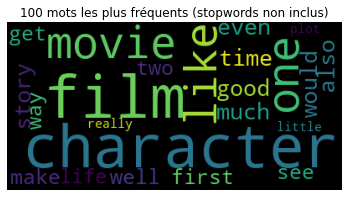

In [7]:
# 100 mots les plus fréquents (word cloud)

most_freq = Counter(" ".join(alltxts_raw).split()).most_common(100)

wordsjoined = " ".join([tup[0] for tup in most_freq])

wc = WordCloud(stopwords=stopwords.words('english')).generate(wordsjoined)

plt.figure()
plt.title("100 mots les plus fréquents (stopwords non inclus)")
plt.imshow(wc)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

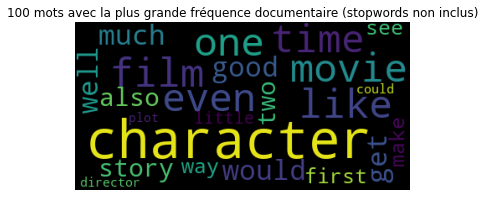

In [8]:
# 100 mots dont la fréquence documentaire est la plus grande

token_textes = []
for i in range(len(alltxts_raw)):
    token_textes.append(" ".join(list(set(nltk.word_tokenize(alltxts_raw[i]))))) # on supprime les doublons
          
most_freq = Counter(" ".join(token_textes).split()).most_common(100) # ainsi le counter compte max un même mot par document

wordsjoined = " ".join([tup[0] for tup in most_freq])

wc = WordCloud(stopwords=stopwords.words('english')).generate(wordsjoined)

plt.figure()
plt.title("100 mots avec la plus grande fréquence documentaire (stopwords non inclus)")
plt.imshow(wc)
plt.axis('off')

In [9]:
# 100 mots les plus discriminants au sens de Odds Ratio
from sklearn.linear_model import LogisticRegression

vect = CountVectorizer()

X = vect.fit_transform(alltxts_raw)

lr = linear_model.LogisticRegression(random_state=42)

lr.fit(X,alllabs_raw)

odds_ratios = np.exp(lr.coef_)

words_100_most_important_oddsratio = np.argsort(np.exp(lr.coef_)) # to get the indices of the 100 most discriminant words
words_discri_idces = words_100_most_important_oddsratio[0][-100:]

feat = vect.get_feature_names_out()
print("Mots les plus discriminants dans l'ordre croissant")
print("Word" + "\t" + "Odd ratio")
for i in words_discri_idces:
    print(feat[i], " ", odds_ratios[0][i])

Word	Odd ratio
things   1.2307223281342536
era   1.2315015783393255
marcy   1.2318034893507674
shot   1.2319111922036985
color   1.2321287807026635
similar   1.2343357740361698
daylight   1.2345745078115833
beavis   1.2352704749967978
most   1.2356814590420322
chemistry   1.2358309931820155
aliens   1.2362920388461778
throughout   1.2374642071074822
thankfully   1.2382289948652991
relationship   1.2385065177163144
gibson   1.2399160858176763
ash   1.2427151311313054
memory   1.2429743055963827
horror   1.2444283992017091
gay   1.2450244450258696
loved   1.2481615068339083
son   1.2496301765633848
ending   1.2500635431478122
political   1.2505895700439442
easily   1.2518141044297684
strange   1.2525027974400307
takes   1.25339674378126
enjoyed   1.2566703121068807
happy   1.2570208519745631
chan   1.259555906896913
above   1.2621112689729694
without   1.2627615831267716
dark   1.2648033909614282
violence   1.264954561599612
life   1.2653682671146886
truman   1.2657749255834947
cameron  

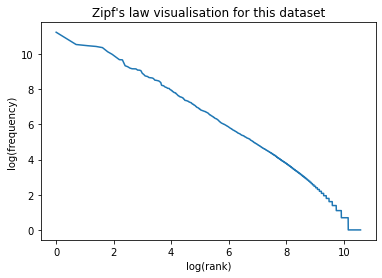

In [10]:
# Zipf's law
from math import log

most_freq = Counter(" ".join(alltxts_raw).split()) # from most frequent word to less frequent
most_freq = dict(sorted(most_freq.items(), key=lambda item: item[1], reverse=True))

cpt = 1
log_rank = []
log_freq = []
for k in most_freq.keys():
    log_rank.append(log(cpt))
    log_freq.append(log(most_freq[k])) # log of frequency of the word k
    cpt += 1
    
plt.plot(log_rank, log_freq)
plt.title("Zipf's law visualisation for this dataset")
plt.xlabel("log(rank)")
plt.ylabel("log(frequency)")
plt.show()

In [11]:
# Most frequent bigrams and trigrams
from nltk.util import ngrams

bigrams = []
trigrams = []
for text in alltxts_raw:
    token = nltk.word_tokenize(text)
    bigrams += ngrams(token,2)
    trigrams += ngrams(token,3)

bigrams_tocount = ["_".join(bigrams[i]) for i in range(len(bigrams))]
trigrams_tocount = ["_".join(trigrams[i]) for i in range(len(trigrams))]

most_freq_bigrams = Counter(bigrams_tocount).most_common(100)
most_freq_trigrams = Counter(trigrams_tocount).most_common(100)

print("Bigrams les plus fréquents :\n", most_freq_bigrams)
print("Trigrams les plus fréquents :\n", most_freq_trigrams)

Bigrams les plus fréquents :
 [('of_the', 8776), ('in_the', 5804), ('the_film', 4541), ('it_s', 3755), ('is_a', 2933), ('to_the', 2775), ('to_be', 2743), ('and_the', 2529), ('in_a', 2253), ('on_the', 2250), ('the_movie', 2151), ('with_the', 1903), ('of_a', 1898), ('for_the', 1893), ('it_is', 1845), ('is_the', 1726), ('as_a', 1712), ('one_of', 1681), ('as_the', 1606), ('this_film', 1539), ('with_a', 1537), ('from_the', 1447), ('at_the', 1338), ('doesn_t', 1270), ('this_is', 1218), ('don_t', 1217), ('that_the', 1198), ('by_the', 1166), ('he_s', 1160), ('and_a', 1058), ('for_a', 1050), ('s_a', 1025), ('out_of', 1017), ('of_his', 1008), ('this_movie', 997), ('there_s', 997), ('the_story', 986), ('the_most', 946), ('he_is', 939), ('film_is', 921), ('in_this', 917), ('the_first', 903), ('isn_t', 870), ('there_is', 831), ('have_been', 818), ('to_a', 813), ('is_not', 806), ('that_s', 787), ('all_the', 776), ('the_same', 775), ('to_see', 770), ('to_make', 759), ('but_it', 756), ('into_the', 754

- **Variantes de BoW**
    - TF-IDF
    - Réduire la taille du vocabulaire (min_df, max_df, max_features)
    - BoW binaire
    - Bi-grams, tri-grams
    - **Quelles performances attendrent? Quels sont les avantages et les inconvénients des ces variantes?**

D'après les différents TMEs ainsi que les 2 premiers cours de RITAL, nous pouvons conclure sur ces points sans tester que :
- TF-IDF est une technique plus performante de vectorisation que le simple Count car plus informatif sur la fréquence documentaire et la fréquence tout court, permet de mieux se focaliser sur les mots-clés du corpus.
- Réduire la taille du vocabulaire est essentiel pour limiter l'overfitting. Enlever les mots les plus couramment utilisés (avec max_df) n'entraîne pas de perte d'information, car ce ne sont souvent pas des mots informatifs. Retirer des mots rares (avec min_df) est aussi une bonne idée car leur présence parasite les résultats (ne donne pas d'information sur le parleur). Enfin, limiter la dimension avec max_features est une bonne idée pour l'overfitting, attention toutefois à ne pas trop en enlever sinon ça retirerait la discrimination nécessaire à la différenciation des deux classes à prédire.
- D'après le cours, le BoW binaire est surtout utile pour la classification de sentiments. Dans le cas de la prédiction de l'orateur du discours, nous avons besoin de la fréquence exacte des mots utilisés, comme la frontière entre deux présidents est plus floue que la frontière entre les sentiments positifs et négatifs.
- Utiliser les bi-grams et tri-grams permet de densifier les données, ce qui peut paraître mauvais d'un point de vue dimensionnel mais donne des informations précieuses sur la sémantique, ce qui peut contribuer à une hausse de précision si on applique un pre-processing suffisamment efficace pour limiter la dimensionnalité.

# C) Modèles de Machine Learning

## 1) Métriques d'évaluation 

Il faudra utiliser des métriques d'évaluation pertinentes suivant la tâche et l'équilibrage des données : 
- Accuracy
- Courbe ROC, AUC, F1-score

In [5]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer

In [6]:
def custom_score(y_true, y_pred):
    score = np.array([accuracy_score(y_true, y_pred), f1_score(y_true, y_pred), f1_score(y_true, y_pred), roc_auc_score(y_true, y_pred)]).mean()
    return score

my_score = make_scorer(custom_score, greater_is_better=True)

## 2) Variantes sur les stratégies d'entraînement

- **Sur-apprentissage**. Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

 <br>
- **Equilibrage des données**. Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

In [7]:
# !pip install imblearn

In [8]:
from imblearn.under_sampling import RandomUnderSampler

def balance_classes(X,y): # rend un nouveau X et un nouveau y qui contient autant un label que l'autre
    X_b,y_b = RandomUnderSampler(random_state=42).fit_resample(np.array(X.copy()).reshape(-1,1), y)
    return [item for sublist in X_b.tolist() for item in sublist], y_b


## 3) Estimer les performances de généralisation d'une méthodes
**Ce sera l'enjeu principal du projet : vous disposez d'un ensemble de données, et vous évaluerez les performances sur un ensemble de test auquel vous n'avez pas accès. Il faut donc être capable d'estimer les performances de généralisation du modèles à partir des données d'entraînement.**


Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

In [9]:
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC # single svc takes too much time to execute
from sklearn.linear_model import LogisticRegression

fname_test = "testSentiment.txt"

def load_movies_test(fname):
    alltxts = open(fname, "r").read().splitlines()
    for i in range(len(alltxts)):
        alltxts[i] = re.sub(r"<br />", " ", alltxts[i])
    return alltxts
    

x_train, y_train = load_movies(path)
x_test = load_movies_test(fname_test)

# x_train, y_train = balance_classes(x_train, y_train) les classes sont déjà équilibrées dans ce dataset

Pour tester l'intérêt de la cross-validation ainsi que déterminer le modèle optimal pour notre problème de classification, nous effectuerons le pre-processing suivant sur les données :

In [10]:
debut = time.time()
bow_train = preproc(x_train, bin_enc=True)
bow_test = preproc(x_test, bin_enc=True)
fin = time.time()
print("Temps de preprocessing total :", fin - debut)

Temps de normalisation : 0.03167867660522461
Temps de mise en minuscule : 0.00659632682800293
Temps de suppression de la ponctuation : 0.024929046630859375
Temps de suppression des nombres : 0.6483676433563232
Temps de suppression des stop words : 8.216162919998169
Temps de lemmatization : 7.722166538238525
Temps de Byte-pair Encoding sur les paires de mots : 6.774325609207153
Temps de vectorisation : 6.103633165359497
Temps de normalisation : 0.16073274612426758
Temps de mise en minuscule : 0.030820369720458984
Temps de suppression de la ponctuation : 0.18124985694885254
Temps de suppression des nombres : 2.6607789993286133
Temps de suppression des stop words : 35.21802306175232
Temps de lemmatization : 28.720091104507446
Temps de Byte-pair Encoding sur les paires de mots : 29.13652229309082
Temps de vectorisation : 26.53450846672058
Temps de preprocessing total : 152.86684560775757


Voir les commentaires disposés çà-et-là dans la définition de la fonction de pre-processing pour comprendre pourquoi nous prenons pour hypothèse que c'est le pre-processing optimal.

On notera que l'ensemble d'entraînement a été balancé, ceci pour permettre à la métrique accuracy d'avoir du sens d'être utilisée et donc avoir des informations plus détaillées sur en tout cas le début de notre optimisation.

De manière générale, limiter au maximum la taille du vocabulaire permet de limiter l'overfitting (réduction de dimensionalité). Donc notre pre-processing s'est attaché à respecter cela.

Définissons tout de suite le modèle optimal, grâce à nos métriques de score.

Nous allons également jouer sur les différents paramètres de chaque modèle, notamment celui touchant à la régularisation, très important pour limiter l'overfitting. Nous utiliserons la métrique F1 pour mesurer cela (meilleure métrique pour les problèmes de classes binaires, et prédire comme il faut les classes positives tout en estimant bien la sensibilité de notre modèle (recall) nous paraît important).

Lançons la compétition entre les modèles, d'abord interne (on joue sur les paramètres d'un seul et même modèle), puis externe (on fait affronter les modèles avec paramètres optimisés entre eux pour définir le "vainqueur").

In [13]:
test_scores = []
train_scores = []

In [14]:
def reglog_opti(bow_train, y_train): # ici, nous allons jouer avec les paramètres que nous estimons déterminants pour le résultat à obtenir
    best_mean = -1
    best_score_f1 = -1
    penalties = ['l1', 'l2', 'elasticnet', None]
    duals = [True, False]
    reg_values = np.arange(0.1, 1.06, 0.05) # regularization in ]0 ; +inf[
    fit_intercepts = [True, False]
    weights_class = ['balanced', None]
    solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    l1_ratios = np.arange(0, 1.05, 0.05) # only for elasticnet penalties
    
    '''
    GridSearch à la main :
    
    cpt = 0
    for reg in reg_values:
        for s in solvers:
            for d in duals:
                for f_t in fit_intercepts:
                    for w_c in weights_class:
                        for l1_r in l1_ratios:
                            for p in penalties:
                                try:
                                    print(cpt+1)
                                    cpt += 1
                                    lr = LogisticRegression(penalty=p, dual=d, C=reg, fit_intercept=f_t, class_weight=w_c, random_state=42, solver=s, l1_ratio=l1_r)
                                    score_acc = cross_val_score(lr, bow_train, y_train, scoring='accuracy', cv=5).mean() # on fait avec le score de la cross validation car plus rapide que fit predict etc
                                    score_f1 = cross_val_score(lr, bow_train, y_train, scoring='f1', cv=5).mean()
                                    score_roc_auc = cross_val_score(lr, bow_train, y_train, scoring='roc_auc', cv=5).mean()
                                    curr_mean = np.array([score_acc, score_f1, score_roc_auc]).mean()
                                    if curr_mean > best_mean:
                                        best_mean = curr_mean
                                        pen_opt = p
                                        dual_opt = d
                                        fit_opt = f_t
                                        c_weight_opt = w_c
                                        solver_opt = s
                                        l1_ratio_opt = l1_r
                                    if score_f1 > best_score_f1: # on utilise uniquement la métrique F1 pour définir la régularisation optimale
                                        reg_opt = reg
                                except ValueError:
                                    pass
    
    return LogisticRegression(penalty=pen_opt, dual=dual_opt, C=reg_opt, fit_intercept=fit_opt, class_weight=c_weight_opt, random_state=42, solver=solver_opt, l1_ratio=l1_ratio_opt)
    '''
    
    lr = LogisticRegression(random_state=42)
    
    grid = {'penalty': penalties,
           'dual': duals,
           'C': reg_values,
           'fit_intercept': fit_intercepts,
           'class_weight': weights_class,
           'solver': solvers,
           'l1_ratio': l1_ratios}
    
    search_est = GridSearchCV(estimator=lr, param_grid=grid, scoring=my_score, n_jobs=-1, return_train_score=True)
    
    search_est.fit(bow_train, y_train)
    
    best_train_score = search_est.cv_results_['mean_train_score'][np.argmin(np.array(search_est.cv_results_['rank_test_score']))]
                                    
    return search_est.best_estimator_, search_est.best_score_, best_train_score

In [20]:
reglog_opt, test_score, train_score = reglog_opti(bow_train, y_train)
test_scores.append(test_score)
train_scores.append(train_score)
print(reglog_opt)

LogisticRegression(C=0.1, class_weight='balanced', dual=True,
                   fit_intercept=False, l1_ratio=0.0, random_state=42,
                   solver='liblinear')


In [15]:
def lsvc_opti(bow_train, y_train): # ici, nous allons jouer avec les paramètres que nous estimons déterminants pour le résultat à obtenir
    best_mean = -1
    best_score_f1 = -1
    penalties = ['l1', 'l2']
    loss_f = ['hinge', 'squared_hinge']
    duals = [True, False]
    reg_values = np.arange(0.1, 1.01, 0.01) # regularization in ]0 ; +inf[
    fit_intercepts = [True, False]
    weights_class = ['balanced', None]
    
    '''
    
    for reg in reg_values:
        for l in loss_f:
            for d in duals:
                for f_t in fit_intercepts:
                    for p in penalties:
                        for w_c in weights_class:
                            try:
                                lsvc = LinearSVC(penalty=p, loss=l, dual=d, C=reg, fit_intercept=f_t, class_weight=w_c, random_state=42)
                                score_acc = cross_val_score(lsvc, bow_train, y_train, scoring='accuracy', cv=5).mean() # on fait avec le score de la cross validation car plus rapide que fit predict etc
                                score_f1 = cross_val_score(lsvc, bow_train, y_train, scoring='f1', cv=5).mean()
                                score_roc_auc = cross_val_score(lsvc, bow_train, y_train, scoring='roc_auc', cv=5).mean()
                                curr_mean = np.array([score_acc, score_f1, score_roc_auc]).mean()
                                if curr_mean > best_mean:
                                    best_mean = curr_mean
                                    pen_opt = p
                                    loss_opt = l
                                    dual_opt = d
                                    fit_opt = f_t
                                    c_weight_opt = w_c
                                if score_f1 > best_score_f1: # on utilise uniquement la métrique F1 pour définir la régularisation optimale
                                    reg_opt = reg
                            except ValueError:
                                pass
    
    return LinearSVC(penalty=pen_opt, loss=loss_opt, dual=dual_opt, C=reg_opt, fit_intercept=fit_opt, class_weight=c_weight_opt, random_state=42)
    
    '''
    
    lsvc = LinearSVC(random_state=42)
    
    grid = {'penalty': penalties,
            'loss': loss_f,
           'dual': duals,
           'C': reg_values,
           'fit_intercept': fit_intercepts,
           'class_weight': weights_class}
    
    search_est = GridSearchCV(estimator=lsvc, param_grid=grid, scoring=my_score, n_jobs=-1, return_train_score=True)
    
    search_est.fit(bow_train, y_train)
    
    best_train_score = search_est.cv_results_['mean_train_score'][np.argmin(np.array(search_est.cv_results_['rank_test_score']))]
                                    
    return search_est.best_estimator_, search_est.best_score_, best_train_score

In [22]:
lsvc_opt, test_score, train_score = lsvc_opti(bow_train, y_train)
test_scores.append(test_score)
train_scores.append(train_score)
print(lsvc_opt)

LinearSVC(C=0.1, class_weight='balanced', dual=False, fit_intercept=False,
          random_state=42)


In [16]:
def mnb_opti(bow_train, y_train):
    best_mean = -1
    alphas = np.arange(1e-4, 1+1e-4, 1e-4)
    fit_priors = [True, False]
    
    '''

    for a in alphas:
        for f_t in fit_priors: # we don't need to optimize more params, since our classes have the same priority (for the class_prior param)
            try:
                mnb = MultinomialNB(alpha=a, fit_prior=f_t)
                score_acc = cross_val_score(mnb, bow_train, y_train, scoring='accuracy', cv=5).mean() # on fait avec le score de la cross validation car plus rapide que fit predict etc
                score_f1 = cross_val_score(mnb, bow_train, y_train, scoring='f1', cv=5).mean()
                score_roc_auc = cross_val_score(mnb, bow_train, y_train, scoring='roc_auc', cv=5).mean()
                curr_mean = np.array([score_acc, score_f1, score_roc_auc]).mean()
                if curr_mean > best_mean:
                    best_mean = curr_mean
                    alpha_opt = a
                    ft_opt = f_t
            except ValueError:
                pass
    
    
    return MultinomialNB(alpha=alpha_opt, fit_prior=ft_opt)
    '''
    
    mnb = MultinomialNB()
    
    grid = {'alpha': alphas,
            'fit_prior': fit_priors}
    
    search_est = GridSearchCV(estimator=mnb, param_grid=grid, scoring=my_score, n_jobs=-1, return_train_score=True)
    
    search_est.fit(bow_train, y_train)
    
    best_train_score = search_est.cv_results_['mean_train_score'][np.argmin(np.array(search_est.cv_results_['rank_test_score']))]
                                    
    return search_est.best_estimator_, search_est.best_score_, best_train_score

In [24]:
mnb_opt, test_score, train_score = mnb_opti(bow_train, y_train)
test_scores.append(test_score)
train_scores.append(train_score)
print(mnb_opt)

MultinomialNB(alpha=0.2938)


In [17]:
def cnb_opti(bow_train, y_train):
    best_mean = -1
    alphas = np.arange(1e-4, 1+1e-4, 1e-4)
    fit_priors = [True, False]
    norms = [True, False]
    
    '''

    for a in alphas:
        for f_t in fit_priors:
            for n in norms:
                try:
                    cnb = ComplementNB(alpha=a, fit_prior=f_t, norm=n)
                    score_acc = cross_val_score(cnb, bow_train, y_train, scoring='accuracy', cv=5).mean() # on fait avec le score de la cross validation car plus rapide que fit predict etc
                    score_f1 = cross_val_score(cnb, bow_train, y_train, scoring='f1', cv=5).mean()
                    score_roc_auc = cross_val_score(cnb, bow_train, y_train, scoring='roc_auc', cv=5).mean()
                    curr_mean = np.array([score_acc, score_f1, score_roc_auc]).mean()
                    if curr_mean > best_mean:
                        best_mean = curr_mean
                        alpha_opt = a
                        ft_opt = f_t
                        norm_opt = n
                except ValueError:
                    pass
                    
    return ComplementNB(alpha=alpha_opt, fit_prior=ft_opt, norm=norm_opt)
    '''
    
    mnb = ComplementNB()
    
    grid = {'alpha': alphas,
            'fit_prior': fit_priors,
            'norm': norms}
    
    search_est = GridSearchCV(estimator=cnb, param_grid=grid, scoring=my_score, n_jobs=-1, return_train_score=True)
    
    search_est.fit(bow_train, y_train)
    
    best_train_score = search_est.cv_results_['mean_train_score'][np.argmin(np.array(search_est.cv_results_['rank_test_score']))]
                                    
    return search_est.best_estimator_, search_est.best_score_, best_train_score

In [26]:
cnb_opt, test_score, train_score = cnb_opti(bow_train, y_train)
test_scores.append(test_score)
train_scores.append(train_score)
print(cnb_opt)

ComplementNB(alpha=0.2938)


In [18]:
print(test_scores)
print(train_scores)

[0.5635557500107666, 0.5539112813974191, 0.5733733648998877, 0.5635557500107666]
[0.8528548915023733, 0.8557823850341091, 0.7626386700256409, 0.8528548915023733]


Déterminons, maintenant que nous avons défini pour chaque classifieur sa version optimale, lequel est le meilleur de tous :

In [19]:
models_opt = [reglog_opt, lsvc_opt, mnb_opt, cnb_opt]
diff_train_test = []
for i in range(len(train_scores)):
    diff_train_test.append(train_scores[i] - test_scores[i]) # théoriquement, les perfs en test sont moins bonnes qu'en training, on stocke ces resultats pour definir l'overfitting de chaque modele

if np.max(np.array(test_scores)).size > 1:
    meilleur_modele = models_opt[np.argmin(np.array(diff_train_test))] # si plusieurs modeles, on renvoie celui qui overfit le moins
else:
    meilleur_modele = models_opt[np.argmax(np.array(test_scores))] # on renvoie le meilleur modèle d'après le score de test

print("Meilleur modèle selon les critères de base :", meilleur_modele)

Meilleur modèle selon les critères de base : MultinomialNB(alpha=0.2938)


Maintenant que nous avons notre modèle optimal, nous allons vérifier si la cross-validation vaut le coup d'être utilisée ou non :

In [11]:
# DEBUG

# meilleur_modele = MultinomialNB(alpha=0.2938)

In [12]:
model = meilleur_modele
scores_cv = []
scores_sp = []
for i in range(100): # on teste 100 fois pour s'assurer du resultat et de sa stabilité
    bow_train_valid, bow_valid, y_train_valid, y_valid = train_test_split(bow_train, y_train, test_size=0.2, random_state=42)
    # notre test_size (qui est en réalité la taille de l'ensemble de validation ici) est de 20%, correspondant au 5-Folds pour la cross val
    model.fit(bow_train_valid, y_train_valid)

    y_pred_valid = model.predict(bow_valid)
    
    my_score_split = custom_score(y_valid, y_pred_valid)
    
    model2 = meilleur_modele
    
    my_score_crossval = cross_val_score(model2, bow_train, y_train, scoring=my_score, cv=5).mean()
    
    scores_cv.append(my_score_crossval)
    scores_sp.append(my_score_split)

print(np.array(scores_cv).mean())
print(np.array(scores_sp).mean())
if np.array(scores_cv).mean() > np.array(scores_sp).mean():
    print("Cross-validation mieux")
else:
    print("Cross-val ne vaut pas le coup, gardons ce modèle.")

0.7116818858075361
0.7356575476886921
Cross-val ne vaut pas le coup, gardons ce modèle.


Nous voyons après exécution de la cellule que la séparation train/test permet de meilleurs résultats... mais il serait tout de même intéressant d'implémenter la cross-validation pour faire des tests supplémentaires (et puis c'est un outil permettant de tester plus exhaustivement notre modèle et ses hyper-paramètres)... quelle valeur de K pour le KFolds serait la plus pertinente ? Nous allons le déterminer maintenant :

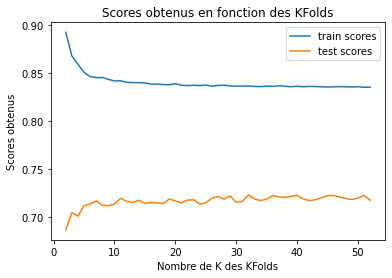

Nombre de K-Folds optimal : 32


In [14]:
model = meilleur_modele

train_scores = []
test_scores = []
diff_train_test = []
def cross_val(est, X, y, metric, nb_k):
    global test_scores, train_scores, diff_train_test
    results = cross_validate(est, X, y, scoring=metric, cv=nb_k, return_train_score=True)
    train_scores.append(results['train_score'].mean())
    test_scores.append(results['test_score'].mean())
    diff_train_test.append(train_scores[-1] - test_scores[-1])
    
    
kf = range(2, 53) # on va faire varier la taille de la proportion train/test de 50/50 à 98/2 (symétriquement 2/98 car cross val)

for kf_i in kf:
    cross_val(model, bow_train, y_train, my_score, kf_i)
        
plt.plot(kf, train_scores, label='train scores')
plt.plot(kf, test_scores, label='test scores')
plt.xlabel('Nombre de K des KFolds')
plt.ylabel('Scores obtenus')
plt.title('Scores obtenus en fonction des KFolds')

plt.legend()
plt.show()

# on recupere le kf maximisant le score de test :
kf_opt = np.argmax(np.array(test_scores))+2

# si plusieurs K trouvés, on prend le K minimisant l'overfit
if kf_opt.size > 1:
    kf_opt = np.argmin(np.array(diff_train_test))+2
    
print("Nombre de K-Folds optimal :", kf_opt)

Maintenant que nous avons notre nombre optimal de Folds, nous pouvons (enfin) trouver notre modèle optimal avec un ensemble d'apprentissage d'une taille permettant à la fois la précision et la limitation du risque d'overfit.

In [15]:
model = meilleur_modele

results = cross_validate(model, bow_train, y_train, scoring=my_score, cv=kf_opt, return_train_score=True, return_estimator=True)

diff_train_test = [] # on va chercher le meilleur des kf_opt modèles selon le minimum d'overfitting possible
for i in range(kf_opt):
    diff_train_test.append(results['test_score'][i] - results['train_score'][i])

model_opt = np.argmax(np.array(results['test_score']))

if model_opt.size > 1:
    model_tofit = results['estimator'][np.argmax(np.array(diff_train_test))] # difference la plus proche de 0 = modèle qui apprend le plus justement (qui overfit le moins)
else:
    model_tofit = results['estimator'][model_opt]

Maintenant que nous avons notre modèle optimisé, nous pouvons définir quel pre-processing est le meilleur pour notre problème :

In [16]:
ngram=[(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)] # most common ngram range
maxfeatures=range(0, 2000, 200)
bin_enc=[True, False]

'''
GridSearchCV à la main
'''

best_score = -1
for ng in ngram:
    for mxf in maxfeatures:
        for b_enc in bin_enc:
            try:  
                bow_train = preproc(x_train,
                                    ngram=ng,
                                    maxfeatures=mxf,
                                    bin_enc=b_enc)
                results = cross_validate(model_tofit, bow_train, y_train, scoring=my_score, cv=kf_opt, return_train_score=True)
                curr_score = results['test_score'].mean()
                if best_score < curr_score:
                    best_score = curr_score
                    best_train_score = results['train_score'].mean()
                    ng_opt = ng
                    mxf_opt = mxf
                    b_enc_opt = b_enc
            except ValueError:
                pass
                                                            

bow_train_opt = preproc(x_train,
                        ngram=ng_opt,
                        maxfeatures=mxf_opt,
                        bin_enc=b_enc_opt)


bow_test_opt = preproc(x_test,
                       ngram=ng_opt,
                       maxfeatures=mxf_opt,
                       bin_enc=b_enc_opt)

Temps de normalisation : 0.019081592559814453
Temps de mise en minuscule : 0.0037794113159179688
Temps de suppression de la ponctuation : 0.014456987380981445
Temps de suppression des nombres : 0.2952585220336914
Temps de suppression des stop words : 4.262086629867554
Temps de lemmatization : 5.072597503662109
Temps de Byte-pair Encoding sur les paires de mots : 5.8369300365448
Temps de normalisation : 0.015182018280029297
Temps de mise en minuscule : 0.003508329391479492
Temps de suppression de la ponctuation : 0.014795064926147461
Temps de suppression des nombres : 0.28705930709838867
Temps de suppression des stop words : 4.034569978713989
Temps de lemmatization : 5.019770860671997
Temps de Byte-pair Encoding sur les paires de mots : 5.703306198120117
Temps de normalisation : 0.016293764114379883
Temps de mise en minuscule : 0.0038039684295654297
Temps de suppression de la ponctuation : 0.016477108001708984
Temps de suppression des nombres : 0.2841322422027588
Temps de suppression de

Nous avons donc à la fois notre pre-processing optimal et notre modèle optimal, nous pouvons désormais fitter le modèle avec nos données et prédire les labels des données de test.

In [17]:
print("Score de test", best_score)
print("Score de train", best_train_score)

Score de test 0.8293503086323324
Score de train 0.8774893096084833


Très léger overfitting, nous pouvons néanmoins nous attendre à un score de ~80% de bonnes prédictions.

In [51]:
import sys

model_tofit.fit(bow_train_opt, y_train)
y_pred = np.where(np.array(model_tofit.predict(bow_test_opt))==1, 'P', 'N')

with open("result_films.txt", "w") as f:
    for y_pred_i in y_pred:
        f.write(y_pred_i+"\n")